모델 1> 텍스트 감정분석 모델  [nlp04/korean_sentiment_analysis_kcelectra]

텍스트 감정분석 모델을 사용하여 브랜드(제품)에 대한 소비자의 이미지, 평판 등의 파악이 가능합니다.

예시> 제품명 "아이폰16E"에 대한 트윗을 수집하고 감정 분석 모델로 긍/부정 감정을 파악한 뒤, 제품 평판 혹은 소비자 만족도를 분석하는 것


방식

1- SNS데이터 수집 

2- 수집된 데이터에 감정분석모델 적용

3- 분석 결과 정리

4- 시각화 및 분석 후 인사이트 도출

In [1]:
#  Hugging face 에서 가져온 텍스트감정분석 모델의 예시입니다.[파이썬 3.13에서는 오류 있어요]

from transformers import pipeline

model_name = "nlp04/korean_sentiment_analysis_kcelectra"
sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)

test_sentence = "정말 최고의 영화였어요!"
result = sentiment_analyzer(test_sentence)

print(result)


# 결과는   >>   [{'label': '기쁨(행복한)', 'score': 0.5651623606681824}]  <<  이런식으로 도출됨


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


[{'label': '기쁨(행복한)', 'score': 0.5651624798774719}]


1 - 트위터 개발자 계정과 연결

In [9]:
import tweepy
from transformers import pipeline
from collections import Counter
import matplotlib.pyplot as plt
import platform

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'


bearer_token = "개인 트위터 API 토큰" # X개발자 토큰 
client = tweepy.Client( bearer_token=bearer_token) 


2 - 트위터 글 수집

In [ ]:
query = "아이폰16E -is:retweet lang:ko"
tweets = client.search_recent_tweets(query=query, max_results=100)

tweet_texts = [tweet.text for tweet in tweets.data]

TooManyRequests: 429 Too Many Requests
Too Many Requests

3 - 모델 설정 및 수행

In [4]:
model_name = "nlp04/korean_sentiment_analysis_kcelectra"
sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)

results = [sentiment_analyzer(text)[0]["label"] for text in tweet_texts]

Device set to use cpu


4 - 통계 집계 

In [6]:
counts = Counter(results)
print(counts)

Counter({'일상적인': 23, '슬픔(우울한)': 2, '생각이 많은': 1, '짜증남': 1, '설레는(기대하는)': 1})


5 - 데이터 정제 및 시각화 

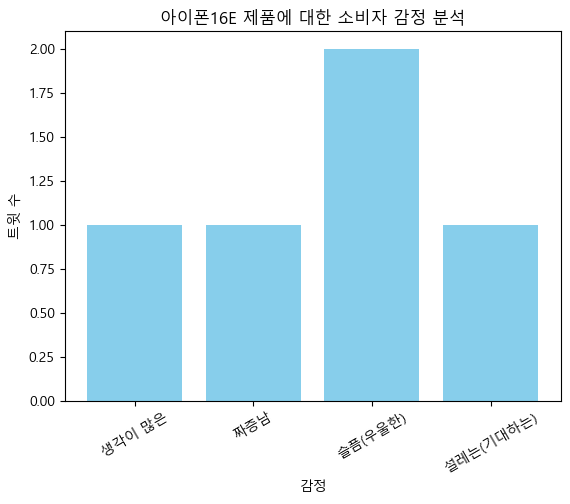

In [8]:
from collections import Counter
filtered_results = [r for r in results if r != '일상적인']
counts = Counter(filtered_results)


fig, ax = plt.subplots()
ax.bar(counts.keys(), counts.values(), color="skyblue")
ax.set(title="아이폰16E 제품에 대한 소비자 감정 분석", xlabel="감정", ylabel="트윗 수")
plt.xticks(rotation=30)
plt.show()

정리: 무료 계정이라 데이터를 가져올 수 있는 양이 적었지만, 제대로 활용한다면<기업차원에서 비용을 들여 API를 활용한다면> 비즈니스적으로 유용한 인사이트를 도출할 수 있을 것이라고 생각합니다. 실제로 아이폰 16E에 대한 평가가 좋지 않은 만큼, 데이터에서도 부정적인 결과값이 (4배) 많음을 알 수 있습니다.
(무료 X.dev 계정의 경우 최근 일주일 간의 데이터만 가져올 수 있었고, 그래서 20개 가량의 트윗밖에 확보하지 못했습니다.)

추가 아이디어들 

시간간별 분석 :	감정 변화를 시간 순으로 분석

키워드 필터링 :	"아이폰16E 배터리", "아이폰16E 디자인" 등 세부 항목 분석

지역 기반 분석 : 지역간 평판 차이 파악가능 

모델 2> 한국어 특화 임베딩 모델  [nlp04/korean_sentiment_analysis_kcelectra]

리뷰 분석 및 클러스터링: 유사한 리뷰를 그룹화하여 주요 개선사항을 도출하고, 우선적인 피드백을 파악하는데 이용할 수 있습니다. 


In [16]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 예시 리뷰 데이터
review_ex = [
    "배터리가 너무 빨리 닳아요.",
    "디자인이 예쁘고 마음에 들어요.",
    "발열이 심해서 불편해요.",
    "배터리가 너무 심각하다.",
    "디자인은 좋은데, 마감이 아쉬움",
    "게임 4시간하니까 배터리 10%남아서 확인해보니 불량이였습니다.",
    "가격 동결 미쳤다.",
    "게임할때 발열이 너무 심함",
    "충전 속도가 느려요.",
    "화면이 깨끗하고 터치가 잘 돼요.",
    "무게가 15g 증가했는데 생각보다 체감됩니다."
    "무게가 너무 무거워요.",
    "열이 많이 나요.",
    "환율때문에 가격 걱정 많았는데 그래도 동결이면 괜찮은듯",
    "배터리 오래 가서 좋음",
    "디자인 좀 더 개선되면 좋겠어요.",
    "터치가 잘 안 돼요."
]

# 1. KURE 임베딩 모델 로드
model = SentenceTransformer("nlpai-lab/KURE-v1")

# 2. 문장 임베딩 생성
embeddings = model.encode(review_ex)

In [17]:
# 3. 클러스터링 (갯수를 정해야 해서 6개로 분류하였습니다.)
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# 4. 데이터프레임으로 정리
df = pd.DataFrame({'리뷰': review_ex, '클러스터': labels})

C:\Users\santa\AppData\Local\Temp\ipykernel_27768\3400556986.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='클러스터', palette='pastel')


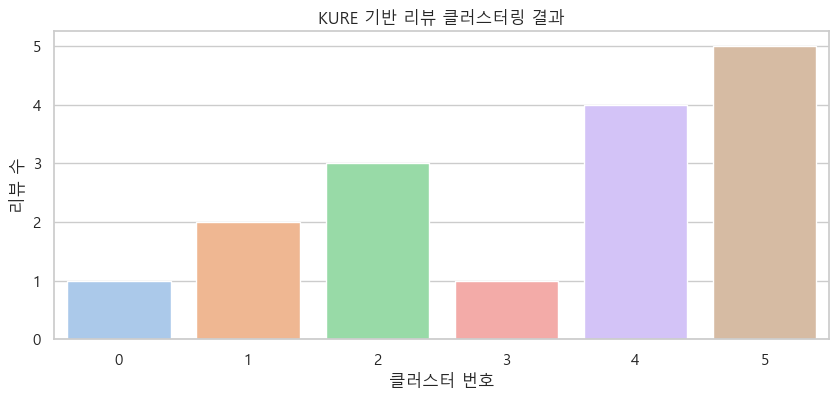

                                       리뷰  클러스터
0                         배터리가 너무 빨리 닳아요.     5
1                       디자인이 예쁘고 마음에 들어요.     4
2                           발열이 심해서 불편해요.     2
3                           배터리가 너무 심각하다.     5
4                       디자인은 좋은데, 마감이 아쉬움     4
5     게임 4시간하니까 배터리 10%남아서 확인해보니 불량이였습니다.     0
6                              가격 동결 미쳤다.     5
7                          게임할때 발열이 너무 심함     2
8                             충전 속도가 느려요.     5
9                      화면이 깨끗하고 터치가 잘 돼요.     1
10  무게가 15g 증가했는데 생각보다 체감됩니다.무게가 너무 무거워요.     5
11                              열이 많이 나요.     2
12         환율때문에 가격 걱정 많았는데 그래도 동결이면 괜찮은듯     4
13                           배터리 오래 가서 좋음     3
14                     디자인 좀 더 개선되면 좋겠어요.     4
15                            터치가 잘 안 돼요.     1


In [18]:
# 5. 클러스터별 시각화
sns.set(style="whitegrid", font="Malgun Gothic")
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='클러스터', palette='pastel')

plt.title("KURE 기반 리뷰 클러스터링 결과")
plt.xlabel("클러스터 번호")
plt.ylabel("리뷰 수")
plt.show()


print(df)

결과: 관련된 리뷰들이 보편적으로 모이긴 했습니다. 예를 들어서 2,7,11 모두 발열 관련 내용이고, 클러스터링번호 2번에 묶여있습니다. 
다만 0,3,13번의 경우 배터리 관련인데 13번은 혼자 5번으로 가있습니다. 

이는 클러스터링 모델이 긍정/부정 차이까지 영향을 받기 때문이며, 개선할 수 있는 방법은, 모델1을 활용해 리뷰의 긍정/부정 내용을 먼저 분석하고 나눈 후, 부정적인 리뷰를 바탕으로 모델을 사용하면, 가장 우선시되는 제품의 피드백 요소를 파악할 수 있을 것이라고 생각합니다. 

결과적으로 이 모델은 단순히 데이터를 분류하는 데에 그치지 않고, 비즈니스 인사이트를 추출하는 데 유용한 도구가 될 수 있습니다.
특히 클러스터별 리뷰 수, 감정 성향을 함께 분석하면 고객이 어떤 문제에 가장 민감하게 반응하는지, 그리고 브랜드의 핵심 개선 포인트가 무엇인지 빠르게 파악할 수 있습니다.

이는 고객 응대, R&D 기획, 마케팅 전략 등 다양한 부서에 활용 가능한 고객 중심 데이터 기반 전략 수립으로 확장될 수 있습니다.



모델 3> 문저 재정렬 모델 [mxbai-rerank-base-v2]

 정보 검색 시스템 등에서 초기 검색된 결과들을 다시 정렬해서 가장 관련성 높은 순으로 재배열하는 데 사용되는 모델 
 이커머스같은 시스템에서 검색 시스템의 개선에 활용이 가능하며, 검색엔진이나 사용자가 찾는 정보를 주는 과정에서 유용할것이라고 생각합니다.
 
 고객 쿼리에 대해 더 연관성 높은 상품 설명 우선 정렬이 가능합니다. 
 

In [52]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch

model_name = "mixedbread-ai/mxbai-rerank-large-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 고객 검색 쿼리
query = "배터리 오래가는 노트북 추천"

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at mixedbread-ai/mxbai-rerank-large-v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
candidates = [
    "고성능 CPU와 배터리 최적화로 하루 종일 사용 가능한 노트북입니다.",
    "가볍고, CPU 좋고, 배터리도 오래가는 노트북",
    "가성비 좋은 노트북 고르는 방법",
    "최신 그래픽이 탑재된 게임용 노트북. 배터리는 4시간.",
    "배터리 교체가 가능한 모델로 장시간 사용에 유리합니다.",
    "가볍고 배터리 오래가는 노트북 추천 부탁드립니다.",
    "슬림한 디자인과 빠른 부팅이 특징인 노트북입니다.",
    "요즘 많이 보이는 노트북 이제품",
    "한번 충전으로 끝가지 간다? 배터리 최강 노트북 톱5",
    "맥북 배터리 vs 노오급 윈도우 노트북들",
    "배터리 정말 오래가는 노트북 있을까요?",
    "노트북 배터리 마라톤의 승자는??",
    "가볍고 cpu 좋고 배터리도 오래가는 노트북 추천",
    "최강 프로세서의 탑제, 이 제품입니다!"
]


In [54]:
# 각 후보에 대해 점수 계산
scores = []
for passage in candidates:
    inputs = tokenizer(query, passage, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = softmax(logits, dim=1)
        score = probs[0][1].item()  # 'relevant' 클래스 확률
        scores.append(score)

In [56]:
# 점수 기준으로 재정렬
reranked = [x for _, x in sorted(zip(scores, candidates), reverse=True)]

# 결과 출력
for i, (score, text) in enumerate(sorted(zip(scores, candidates), reverse=True), 1):
    print(f"{i}위 (점수: {score:.4f}): {text}")

1위 (점수: 0.9676): 한번 충전으로 끝가지 간다? 배터리 최강 노트북 톱5
2위 (점수: 0.9658): 가볍고, CPU 좋고, 배터리도 오래가는 노트북
3위 (점수: 0.9590): 가성비 좋은 노트북 고르는 방법
4위 (점수: 0.9552): 요즘 많이 보이는 노트북 이제품
5위 (점수: 0.9389): 가볍고 cpu 좋고 배터리도 오래가는 노트북 추천
6위 (점수: 0.9386): 최강 프로세서의 탑제, 이 제품입니다!
7위 (점수: 0.9371): 고성능 CPU와 배터리 최적화로 하루 종일 사용 가능한 노트북입니다.
8위 (점수: 0.9367): 배터리 정말 오래가는 노트북 있을까요?
9위 (점수: 0.9356): 최신 그래픽이 탑재된 게임용 노트북. 배터리는 4시간.
10위 (점수: 0.9000): 배터리 교체가 가능한 모델로 장시간 사용에 유리합니다.
11위 (점수: 0.8977): 맥북 배터리 vs 노오급 윈도우 노트북들
12위 (점수: 0.8615): 가볍고 배터리 오래가는 노트북 추천 부탁드립니다.
13위 (점수: 0.8581): 노트북 배터리 마라톤의 승자는??
14위 (점수: 0.8110): 슬림한 디자인과 빠른 부팅이 특징인 노트북입니다.


결론 : 사용자가 원하는 쿼리를 바탕으로 결과값을 재정렬함으로써, 최적의 결과값을 도출해낼 수 있게 되는 비즈니스적 해결이 가능합니다.

고객이 원하는 정보는 무엇이고, 시스템이 뭘 우선순위로 보는가를 파악 할 수 있지만, 모델의 한계로 사용자의 클릭률이 낮다면, 모델과 실제 판단 사이에 차이가 존재한다는 뜻이므로, 피드백 루프의 설계 또한 가능합니다.

